In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
import category_encoders as ce
import xgboost as xgb
from datetime import datetime

# TRAIN

In [2]:
train = pd.read_csv(r'D:\Data Science\Projects\Housing Project\Data\train.csv')
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
# train = pd.read_csv(r'/Users/kimberly/Documents/GitHub/githubtest/Data/train.csv')

## FillNA Functions

In [4]:
def fillna_groupby_train(df, feature, group, agg_funct):
    df[feature] = df.groupby(group)[feature].transform(lambda x: x.fillna(x.agg(agg_funct).iloc[0]))
    return df

# def fillna_mode_groupby_test(test, feature, group):
#     mode_dict = train.groupby(group)[feature].apply(lambda x: x.mode().iloc[0]).to_dict()
#     test.loc[test[feature].isnull(), feature] = test[group].map(mode_dict)
#     return test

# def fillna_mean_groupby_test(test, feature, group):
#     mode_dict = train.groupby(group)[feature].apply(lambda x: x.mean()).to_dict()
#     test.loc[test[feature].isnull(), feature] = test[group].map(mode_dict)
#     return test


def fillna_NA(df, feature):
    df[feature] = np.where(df[feature].isnull(), 'NA', df[feature])
    return df

def fillna_ZERO(df, feature):
    df[feature] = np.where(df[feature].isnull(), 0, df[feature])
    return df

def fillna__NA_basedon_feat_equalzero(df, depend_feat, feature):
    df[feature] = np.where((df[feature].isnull()) & (df[depend_feat]==0), 'NA', df[feature])
    return df

def fillna__NA_basedon_feat_greaterzero(df, depend_feat, feature):
    df[feature] = np.where((df[feature].isnull()) & (df[depend_feat]> 0), 'NA', df[feature])
    return df

def fillna__value_basedon_feat_greaterzero(df, depend_feat, feature, value):
    df[feature] = np.where((df[feature].isnull()) & (df[depend_feat]> 0), value, df[feature])
    return df

def fillna__mode(df, feature):
    df[feature] = np.where(df[feature].isnull(), df[feature].mode(), df[feature])
    return df

def fillna_mean(df, feature):
    df[feature] = np.where(df[feature].isnull(), df[feature].mean(), df[feature])
    return df

def fillna_mode_test(test, train, feature):
    test[feature] = np.where(test[feature].isnull(), train[feature].mode(), test[feature])
    return test

def fillna_ZERO_basedon_feat_equalzero(df, depend_feat, feature):
    df[feature] = np.where((df[feature].isnull()) & (df[depend_feat]==0), 0, df[feature])
    return df

def fillna_otherfeat(df, depend_feat, feature):
    df[feature] = np.where(df[feature].isnull(), df[depend_feat], df[feature])
    return df
 
# Train Functions
def fillna_mode_groupby_test(test, feature, group):
    mode_dict = train.groupby(group)[feature].apply(lambda x: x.mode().iloc[0]).to_dict()
    test.loc[test[feature].isnull(), feature] = test[group].map(mode_dict)
    return test

def fillna_mean_groupby_test(test, feature, group):
    mode_dict = train.groupby(group)[feature].apply(lambda x: x.mean()).to_dict()
    test.loc[test[feature].isnull(), feature] = test[group].map(mode_dict)
    return test

# FillNA Specific Features
def fillna_MiscFeature(df):
    df['MiscFeature'] = np.where((df['MiscFeature'].isnull()) & (df['GarageType']=='2Types'), 'Gar2', df['MiscFeature'])
    df['MiscFeature'] = np.where(df['MiscFeature'].isnull(), 'NA', df['MiscFeature'])
    return df

def fillna_BsmtFinType2(df):
    df['BsmtFinType2'] = np.where((df['BsmtFinType2'].isnull() & df['BsmtUnfSF'] > 0), 'Unf', df['BsmtFinType2'])
    df['BsmtFinType2'] = np.where(df['BsmtFinType2'].isnull(), 'NA', df['BsmtFinType2'])
    return df

def fillna_test_GarageQual(df):
    mode_dict = train.groupby('GarageFinish')['GarageQual'].apply(lambda x: x.mode().iloc[0]).to_dict()
    df.loc[df['GarageQual'].isnull(), 'GarageQual'] = df['GarageFinish'].map(mode_dict)
    return df      

def fillna_test_GarageCond(df):
    mode_dict = train.groupby('GarageFinish')['GarageCond'].apply(lambda x: x.mode().iloc[0]).to_dict()
    df.loc[df['GarageCond'].isnull(), 'GarageCond'] = df['GarageFinish'].map(mode_dict)
    

## Feature Engineering Functions

In [5]:
def feateng_age(df, feat, newfeat):
    df[newfeat] = datetime.now().year - df[feat]
    return df

def feateng_ratio(df, feat1, feat2, newfeat):
    df[newfeat] = (df[feat1]/df[feat2]).round(2)
    return df

def feateng_has_YN(df, feat, newfeat):
    df[newfeat]= np.where(df[feat]=='Y', 1, 0)
    return df

def feateng_has_greaterzero(df, feat, newfeat):
    df[newfeat] = df[feat].apply(lambda x: 1 if x > 0 else 0)
    return df

## Transformation Functions

In [6]:
def log_feat(df):
    skewed_feats = df.skew(numeric_only=True)[df.skew(numeric_only=True) > 0.75]
    for feat in skewed_feats.index:
        df[feat] = np.log1p(df[feat])

In [7]:
def log_each_feat(df, feat):
    df[feat] = np.log1p(df[feat])
    return df

## Datatype Functions

In [8]:
def convert_dtype(df, feat, dtype):
    df[feat] = df[feat].astype(dtype)
    return 

def convert_datetime_year(df, feat):
    df[feat] = pd.to_datetime(df[feat], format='%Y').dt.year
    return df

def convert_datetime_month(df, feat):
    df[feat] = pd.to_datetime(df[feat], format='%m').dt.month
    return df

def convert_datetime_number_year(df, feat):
    df[feat] = pd.to_datetime(df[feat], format='%Y').dt.strftime('%Y')
    return df

# def convert_datetime_number_month(df, feat):
#     df[feat] = pd.to_datetime(df[feat], format='%m').dt.month
#     return df

def convert_float_int(df, feat):
    df[feat] = df[feat].astype(int)

## Outliers

In [9]:
train = train.drop(train[train['LotArea']> 150000].index).reset_index(drop=True)

## Fill Null Features

In [10]:
### Categorical Features
fillna__NA_basedon_feat_equalzero(train, 'PoolArea', 'PoolQC')
fillna_MiscFeature(train)
fillna_NA(train, ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'Fence'])
fillna__NA_basedon_feat_equalzero(train, 'Fireplaces', 'FireplaceQu')#
fillna__NA_basedon_feat_equalzero(train, 'GarageCars', 'GarageType')
fillna__NA_basedon_feat_equalzero(train, 'GarageCars', 'GarageCond')
fillna__NA_basedon_feat_equalzero(train, 'GarageCars', 'GarageQual')
fillna__NA_basedon_feat_equalzero(train, 'GarageCars', 'GarageFinish')
fillna_BsmtFinType2(train)
fillna__NA_basedon_feat_equalzero(train, 'TotalBsmtSF', 'BsmtExposure')
fillna__mode(train, ['Electrical', 'BsmtExposure'])

### Numerical Features
fillna_groupby_train(train, 'LotFrontage', 'Neighborhood', 'mode')
fillna_ZERO(train, 'MasVnrArea')#
fillna_ZERO_basedon_feat_equalzero(train, 'GarageCars', 'GarageYrBlt')


train.isnull().sum().sort_values(ascending=False)

Id             0
CentralAir     0
GarageYrBlt    0
GarageType     0
FireplaceQu    0
              ..
MasVnrArea     0
MasVnrType     0
Exterior2nd    0
Exterior1st    0
SalePrice      0
Length: 81, dtype: int64

## Feature Engineering 

In [11]:
feateng_age(train, 'YearBuilt', 'age')
feateng_age(train, 'YearRemodAdd', 'remodel_age')
feateng_ratio(train, 'GrLivArea', 'LotArea', 'livingtolot')
feateng_has_YN(train, 'PavedDrive', 'has_drivewaypaved')
feateng_has_greaterzero(train, 'Fireplaces', 'has_fireplace')
feateng_has_greaterzero(train, 'PoolArea', 'has_pool')
feateng_has_YN(train, '2ndFlrSF', 'has_2ndstory')
feateng_has_YN(train, 'TotalBsmtSF', 'has_basement')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,SaleCondition,SalePrice,age,remodel_age,livingtolot,has_drivewaypaved,has_fireplace,has_pool,has_2ndstory,has_basement
0,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,Normal,208500,21,21,0.20,1,0,0,0,0
1,2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,Normal,181500,48,48,0.13,1,1,0,0,0
2,3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,Normal,223500,23,22,0.16,1,1,0,0,0
3,4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,Abnorml,140000,109,54,0.18,1,1,0,0,0
4,5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,Normal,250000,24,24,0.15,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,1456,60,RL,62.0,7917,Pave,NA,Reg,Lvl,AllPub,...,Normal,175000,25,24,0.21,1,1,0,0,0
1453,1457,20,RL,85.0,13175,Pave,NA,Reg,Lvl,AllPub,...,Normal,210000,46,36,0.16,1,1,0,0,0
1454,1458,70,RL,66.0,9042,Pave,NA,Reg,Lvl,AllPub,...,Normal,266500,83,18,0.26,1,1,0,0,0
1455,1459,20,RL,68.0,9717,Pave,NA,Reg,Lvl,AllPub,...,Normal,142125,74,28,0.11,1,0,0,0,0


## Transformation

In [12]:
train.skew(numeric_only=True)[train.skew(numeric_only=True) > .75]

MSSubClass        1.405043
LotFrontage       2.149244
LotArea           6.186717
MasVnrArea        2.684427
BsmtFinSF1        1.695853
BsmtFinSF2        4.288669
BsmtUnfSF         0.919753
TotalBsmtSF       1.532585
1stFlrSF          1.384597
2ndFlrSF          0.812622
LowQualFinSF      9.001760
GrLivArea         1.372562
BsmtHalfBath      4.130622
KitchenAbvGr      4.483125
WoodDeckSF        1.514684
OpenPorchSF       2.364643
EnclosedPorch     3.085809
3SsnPorch        10.293487
ScreenPorch       4.117285
PoolArea         14.812955
MiscVal          24.519727
SalePrice         1.893486
livingtolot       2.867890
has_pool         14.337743
dtype: float64

In [13]:
# These features had a skew of 0.75+ which needed to be normalized

skewed_feats = [
'MSSubClass',
'LotFrontage',
'LotArea',
'MasVnrArea',
'BsmtFinSF1',
'BsmtFinSF2',
'BsmtUnfSF',
'TotalBsmtSF',
'1stFlrSF',
'2ndFlrSF',
'LowQualFinSF',
'GrLivArea',
'BsmtHalfBath',
'KitchenAbvGr',
'WoodDeckSF',
'OpenPorchSF',
'EnclosedPorch',
'3SsnPorch',
'ScreenPorch',
'PoolArea',
'MiscVal',
'SalePrice',
'livingtolot',
'has_pool'
]

log_each_feat(train, skewed_feats)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,SaleCondition,SalePrice,age,remodel_age,livingtolot,has_drivewaypaved,has_fireplace,has_pool,has_2ndstory,has_basement
0,1,4.110874,RL,4.189655,9.042040,Pave,NA,Reg,Lvl,AllPub,...,Normal,12.247699,21,21,0.182322,1,0,0.0,0,0
1,2,3.044522,RL,4.394449,9.169623,Pave,NA,Reg,Lvl,AllPub,...,Normal,12.109016,48,48,0.122218,1,1,0.0,0,0
2,3,4.110874,RL,4.234107,9.328212,Pave,NA,IR1,Lvl,AllPub,...,Normal,12.317171,23,22,0.148420,1,1,0.0,0,0
3,4,4.262680,RL,4.110874,9.164401,Pave,NA,IR1,Lvl,AllPub,...,Abnorml,11.849405,109,54,0.165514,1,1,0.0,0,0
4,5,4.110874,RL,4.442651,9.565284,Pave,NA,IR1,Lvl,AllPub,...,Normal,12.429220,24,24,0.139762,1,1,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,1456,4.110874,RL,4.143135,8.976894,Pave,NA,Reg,Lvl,AllPub,...,Normal,12.072547,25,24,0.190620,1,1,0.0,0,0
1453,1457,3.044522,RL,4.454347,9.486152,Pave,NA,Reg,Lvl,AllPub,...,Normal,12.254868,46,36,0.148420,1,1,0.0,0,0
1454,1458,4.262680,RL,4.204693,9.109746,Pave,NA,Reg,Lvl,AllPub,...,Normal,12.493133,83,18,0.231112,1,1,0.0,0,0
1455,1459,3.044522,RL,4.234107,9.181735,Pave,NA,Reg,Lvl,AllPub,...,Normal,11.864469,74,28,0.104360,1,0,0.0,0,0


## Datatype conversions

In [14]:
convert_dtype(train, ['MSSubClass', 'OverallCond', 'GarageFinish'], 'str')
convert_dtype(train, ['LotFrontage', 'MasVnrArea'], 'int')
convert_datetime_year(train, 'YearBuilt')
convert_datetime_year(train, 'YearRemodAdd')
convert_datetime_month(train, 'MoSold')
convert_datetime_number_year(train, 'YrSold')
convert_float_int(train, 'GarageYrBlt')

## Encoding/Scaling

In [15]:
df = train.copy()

In [16]:
ord_feats_edit = [
'LotShape',
'LandContour',
'LandSlope',
'OverallQual',
'OverallCond',
'ExterQual',
'ExterCond',
'BsmtQual',
'BsmtCond',
'BsmtExposure',
'BsmtFinType1',
'BsmtFinType2',
'HeatingQC',
'CentralAir',
'KitchenQual',
'Functional',
'FireplaceQu',
'GarageYrBlt',
'GarageFinish',
'GarageQual',
'GarageCond',
'MiscVal',
'age',
'remodel_age',
]

nom_feats_edit = [
'MSSubClass',
'MSZoning',
'LotConfig',
'Neighborhood',
'Condition1',
'Condition2',
'BldgType',
'HouseStyle',
'RoofStyle',
'RoofMatl',
'Exterior1st',
'Exterior2nd',
'MasVnrType',
'Foundation',
'Heating',
'Electrical',
'GarageType',
'PavedDrive',
'SaleType',
'SaleCondition',
'has_drivewaypaved',
'has_fireplace',
'has_2ndstory',
'has_basement'
]


cont_feats_edit = [
'LotFrontage',
'LotArea',
'MasVnrArea',
'BsmtFinSF1',
'BsmtFinSF2',
'BsmtUnfSF',
'TotalBsmtSF',
'1stFlrSF',
'2ndFlrSF',
'LowQualFinSF',
'GrLivArea',
'BsmtFullBath',
'BsmtHalfBath',
'FullBath',
'HalfBath',
'BedroomAbvGr',
'KitchenAbvGr',
'GarageCars',
'GarageArea',
'WoodDeckSF',
'OpenPorchSF',
'EnclosedPorch',
'3SsnPorch',
'PoolArea',
'MoSold',
'YrSold'
]


In [17]:
ord = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
ord.fit(train[ord_feats_edit])
ord_feats_encoded = ord.transform(train[ord_feats_edit])
new_ord_feats = pd.DataFrame(ord_feats_encoded, columns=train[ord_feats_edit].columns)
df.drop(columns=train[ord_feats_edit], inplace=True)
df = df.merge(new_ord_feats, left_index=True, right_index=True)

one = ce.OneHotEncoder(use_cat_names=True)
one.fit(train[nom_feats_edit])
nom_feats_encoded = one.transform(train[nom_feats_edit])
df.drop(columns=train[nom_feats_edit], inplace=True)
df = df.merge(nom_feats_encoded, left_index=True, right_index=True)

scaler_minmax = MinMaxScaler()
scaler_minmax.fit(train[cont_feats_edit])
cont_feats_scaled = scaler_minmax.transform(train[cont_feats_edit])
new_cont_feats = pd.DataFrame(cont_feats_scaled, columns=train[cont_feats_edit].columns)
df.drop(columns=train[cont_feats_edit], inplace=True)
df = df.merge(new_cont_feats, left_index=True, right_index=True)


## Feature Correlation

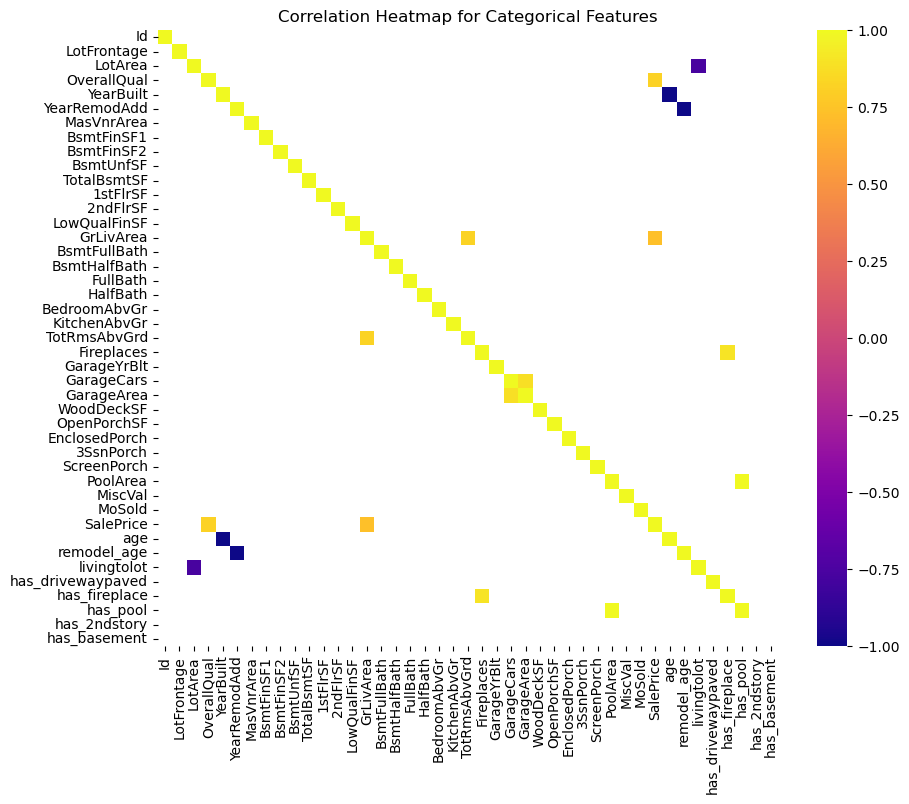

In [18]:
plt.figure(figsize=(10,8),)
sns.heatmap((train.corr(numeric_only=True)[(train.corr(numeric_only=True) >= 0.7) | (train.corr(numeric_only=True) <= -0.7)]), cmap='plasma', annot=False, annot_kws={"size": 1, "color": 'black'})
plt.title('Correlation Heatmap for Categorical Features')
plt.show()

## Train Test Split

In [19]:
# The correlation heatmap determined that the following features had high multicolinearity +0.7/-0.7 so they will be dropped: 
# Utilities, YearBuilt, YearRemodAdd, PoolQC, Fence, livingtolot, Street, Alley, MiscFeature, has_pool, TotRmsAbvGrd, Fireplaces, ScreenPorch

y = df['SalePrice']
x = df.drop([
'Id', 
'SalePrice', 
'GarageArea',
'livingtolot',
'Fireplaces',
'TotRmsAbvGrd',
'YearBuilt',
'YearRemodAdd',
'has_pool',
'ScreenPorch',
'PoolQC',
'MiscFeature',
'Alley',
'Fence',
'Utilities',
'Street'
], axis=1)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((1165, 224), (1165,), (292, 224), (292,))

## Lasso

In [20]:
l = Lasso(alpha=.0011)
lasso_model = l.fit(xtrain, ytrain)
test_pred = lasso_model.predict(xtest)
train_pred = lasso_model.predict(xtrain)
ytrain = np.expm1(ytrain)
ytest = np.expm1(ytest)
test_pred = np.expm1(test_pred)
train_pred = np.expm1(train_pred)
print('RMSE Test:', mean_squared_error(ytest, test_pred)**0.5)
print('RMSE Train:', mean_squared_error(ytrain, train_pred)**0.5)

RMSE Test: 35018.2315069255
RMSE Train: 25516.5422957769


# TEST

In [21]:
test = pd.read_csv(r'D:\Data Science\Projects\Housing Project\Data\test.csv')

In [22]:
# test = pd.read_csv(r'/Users/kimberly/Documents/GitHub/githubtest/Data/test.csv')

In [23]:
test.isnull().sum().sort_values(ascending=False)

PoolQC           1456
MiscFeature      1408
Alley            1352
Fence            1169
MasVnrType        894
                 ... 
Electrical          0
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
SaleCondition       0
Length: 80, dtype: int64

## Fill Null Features

In [24]:
### Categorical Features
fillna__NA_basedon_feat_equalzero(test, 'PoolArea', 'PoolQC')
fillna_mode_test(test, train, 'PoolQC')
fillna_MiscFeature(test)
fillna_NA(test, 'MiscFeature')
fillna_NA(test, 'Alley')
fillna_NA(test, 'Fence')
fillna_NA(test, 'MasVnrType')
fillna__NA_basedon_feat_equalzero(test, 'Fireplaces', 'FireplaceQu')

fillna__NA_basedon_feat_equalzero(test, 'GarageArea', 'GarageCond')#
fillna_test_GarageCond(test)
fillna__mode(test, 'GarageCond')
# fillna_mode_groupby_test(test, 'GarageCond', 'GarageFinish')#

fillna__NA_basedon_feat_equalzero(test, 'GarageArea', 'GarageFinish')
fillna_mode_groupby_test(test, 'GarageQual', 'GarageFinish')
fillna_mode_test(test, train, 'GarageFinish')

fillna__NA_basedon_feat_equalzero(test, 'GarageArea', 'GarageQual')#
# fillna_mode_groupby_test(test, 'GarageFinish', 'GarageQual')#
fillna_test_GarageQual(test)

fillna__NA_basedon_feat_equalzero(test, 'GarageArea', 'GarageType')
fillna_NA(test, 'BsmtCond')
fillna_NA(test, 'BsmtQual')
fillna__NA_basedon_feat_equalzero(test, 'TotalBsmtSF', 'BsmtExposure')
fillna_mode_test(test, train, 'BsmtExposure')
fillna_BsmtFinType2(test)
fillna_NA(test, 'BsmtFinType2')
fillna_NA(test, 'BsmtFinType1')
fillna_mode_groupby_test(test, 'MSZoning', 'Neighborhood')
fillna_mode_test(test, train, 'Utilities')
fillna_mode_test(test, train, 'Functional')
fillna_mode_test(test, train, 'Exterior2nd')
fillna_mode_groupby_test(test, 'KitchenQual', 'KitchenAbvGr')
fillna_mode_test(test, train, 'KitchenQual')
fillna_mode_test(test, train, 'SaleType')
fillna_mode_test(test, train, 'Exterior1st')


### Numerical Features
fillna_mean_groupby_test(test,'LotFrontage', 'Neighborhood')
fillna_ZERO_basedon_feat_equalzero(test, 'GarageArea', 'GarageYrBlt')
fillna_otherfeat(test, 'YearRemodAdd', 'GarageYrBlt')
fillna_ZERO(test, 'MasVnrArea')
fillna_ZERO(test, 'BsmtFullBath')
fillna_ZERO(test, 'BsmtHalfBath')
fillna_ZERO(test, 'BsmtFinSF2')
fillna_mode_test(test, train, 'GarageCars')
fillna_mean(test, 'GarageArea')
fillna_ZERO(test, 'TotalBsmtSF')
fillna_ZERO(test, 'BsmtUnfSF')
fillna_ZERO(test, 'BsmtFinSF1')



# fillna_mode_test(test, train, 'Neighborhood')
# fillna_mode_groupby_test(test, 'Electrical', 'MSZoning')

test.isnull().sum().sort_values(ascending=False)





Id               0
MSSubClass       0
GarageType       0
FireplaceQu      0
Fireplaces       0
                ..
MasVnrType       0
Exterior2nd      0
Exterior1st      0
RoofMatl         0
SaleCondition    0
Length: 80, dtype: int64

In [25]:
test.groupby('GarageFinish')['GarageCond'].apply(lambda x: x.mode().iloc[0])

GarageFinish
Fin    TA
NA     NA
RFn    TA
Unf    TA
Name: GarageCond, dtype: object

In [26]:
test['GarageFinish'].value_counts()

GarageFinish
Unf    627
RFn    389
Fin    367
NA      76
Name: count, dtype: int64

In [27]:
test[test['GarageFinish']=='Unf'][['GarageCond']].value_counts(dropna=False)

GarageCond
TA            580
Fa             39
Po              7
Gd              1
Name: count, dtype: int64

In [28]:
test[test['GarageCond'].isnull()][['GarageFinish','GarageCond']]

,GarageFinish,GarageCond


In [29]:
test['GarageCond'].value_counts(dropna=False)

GarageCond
TA    1330
NA      76
Fa      39
Po       7
Gd       6
Ex       1
Name: count, dtype: int64

## Feature Engineering

In [30]:
feateng_age(test, 'YearBuilt', 'age')
feateng_age(test, 'YearRemodAdd', 'remodel_age')
feateng_ratio(test, 'GrLivArea', 'LotArea', 'livingtolot')
feateng_has_YN(test, 'PavedDrive', 'has_drivewaypaved')
feateng_has_greaterzero(test, 'Fireplaces', 'has_fireplace')
feateng_has_greaterzero(test, 'PoolArea', 'has_pool')
feateng_has_YN(test, '2ndFlrSF', 'has_2ndstory')
feateng_has_YN(test, 'TotalBsmtSF', 'has_basement')


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,SaleType,SaleCondition,age,remodel_age,livingtolot,has_drivewaypaved,has_fireplace,has_pool,has_2ndstory,has_basement
0,1461,20,RH,80.0,11622,Pave,NA,Reg,Lvl,AllPub,...,WD,Normal,63,63,0.08,1,0,0,0,0
1,1462,20,RL,81.0,14267,Pave,NA,IR1,Lvl,AllPub,...,WD,Normal,66,66,0.09,1,0,0,0,0
2,1463,60,RL,74.0,13830,Pave,NA,IR1,Lvl,AllPub,...,WD,Normal,27,26,0.12,1,1,0,0,0
3,1464,60,RL,78.0,9978,Pave,NA,IR1,Lvl,AllPub,...,WD,Normal,26,26,0.16,1,1,0,0,0
4,1465,120,RL,43.0,5005,Pave,NA,IR1,HLS,AllPub,...,WD,Normal,32,32,0.26,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NA,Reg,Lvl,AllPub,...,WD,Normal,54,54,0.56,1,0,0,0,0
1455,2916,160,RM,21.0,1894,Pave,NA,Reg,Lvl,AllPub,...,WD,Abnorml,54,54,0.58,1,0,0,0,0
1456,2917,20,RL,160.0,20000,Pave,NA,Reg,Lvl,AllPub,...,WD,Abnorml,64,28,0.06,1,1,0,0,0
1457,2918,85,RL,62.0,10441,Pave,NA,Reg,Lvl,AllPub,...,WD,Normal,32,32,0.09,1,0,0,0,0


## Transformation

In [31]:
# Need to transform the same exact features that were in Train dataset

skewed_feats = [
'MSSubClass',
'LotFrontage',
'LotArea',
'MasVnrArea',
'BsmtFinSF1',
'BsmtFinSF2',
'BsmtUnfSF',
'TotalBsmtSF',
'1stFlrSF',
'2ndFlrSF',
'LowQualFinSF',
'GrLivArea',
'BsmtHalfBath',
'KitchenAbvGr',
'WoodDeckSF',
'OpenPorchSF',
'EnclosedPorch',
'3SsnPorch',
'ScreenPorch',
'PoolArea',
'MiscVal',
'livingtolot',
'has_pool'
]

log_each_feat(test, skewed_feats)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,SaleType,SaleCondition,age,remodel_age,livingtolot,has_drivewaypaved,has_fireplace,has_pool,has_2ndstory,has_basement
0,1461,3.044522,RH,4.394449,9.360741,Pave,NA,Reg,Lvl,AllPub,...,WD,Normal,63,63,0.076961,1,0,0.0,0,0
1,1462,3.044522,RL,4.406719,9.565775,Pave,NA,IR1,Lvl,AllPub,...,WD,Normal,66,66,0.086178,1,0,0.0,0,0
2,1463,4.110874,RL,4.317488,9.534668,Pave,NA,IR1,Lvl,AllPub,...,WD,Normal,27,26,0.113329,1,1,0.0,0,0
3,1464,4.110874,RL,4.369448,9.208238,Pave,NA,IR1,Lvl,AllPub,...,WD,Normal,26,26,0.148420,1,1,0.0,0,0
4,1465,4.795791,RL,3.784190,8.518392,Pave,NA,IR1,HLS,AllPub,...,WD,Normal,32,32,0.231112,1,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,5.081404,RM,3.091042,7.568896,Pave,NA,Reg,Lvl,AllPub,...,WD,Normal,54,54,0.444686,1,0,0.0,0,0
1455,2916,5.081404,RM,3.091042,7.546974,Pave,NA,Reg,Lvl,AllPub,...,WD,Abnorml,54,54,0.457425,1,0,0.0,0,0
1456,2917,3.044522,RL,5.081404,9.903538,Pave,NA,Reg,Lvl,AllPub,...,WD,Abnorml,64,28,0.058269,1,1,0.0,0,0
1457,2918,4.454347,RL,4.143135,9.253591,Pave,NA,Reg,Lvl,AllPub,...,WD,Normal,32,32,0.086178,1,0,0.0,0,0


## Datatype conversions

In [32]:
convert_dtype(test, ['MSSubClass', 'OverallCond', 'GarageFinish'], 'str')
convert_dtype(test, ['LotFrontage', 'MasVnrArea'], 'int')
convert_datetime_year(test, 'YearBuilt')
convert_datetime_year(test, 'YearRemodAdd')
convert_datetime_month(test, 'MoSold')
convert_datetime_number_year(test, 'YrSold')
convert_float_int(test, 'GarageYrBlt')

## Encoding/Scaling

In [33]:
ord_feats_encoded = ord.transform(test[ord_feats_edit])
new_ord_feats = pd.DataFrame(ord_feats_encoded, columns = test[ord_feats_edit].columns)
test.drop(columns=test[ord_feats_edit], inplace=True)
test = test.merge(new_ord_feats, left_index=True, right_index=True)

nom_feats_encoded = one.transform(test[nom_feats_edit])
test.drop(columns=test[nom_feats_edit], inplace=True)
test = test.merge(nom_feats_encoded, right_index=True, left_index=True)

cont_feats_scaled = scaler_minmax.transform(test[cont_feats_edit])
new_cont_feats = pd.DataFrame(cont_feats_scaled, columns=test[cont_feats_edit].columns)
test.drop(columns=test[cont_feats_edit], inplace=True)
test = test.merge(new_cont_feats, right_index=True, left_index=True)

In [34]:
set(xtrain.columns.tolist()) - set(test.columns.tolist())
set(test.columns.tolist()) - set(df.columns.tolist())
df_test = test.reindex(columns=xtrain.columns).fillna(0)
df_test = df_test[xtrain.columns]

price_pred_test = lasso_model.predict(df_test)
price_pred_test = np.expm1(price_pred_test)
price_pred_test

array([111520.98161568, 156973.10609735, 179807.64479301, ...,
       162680.61508632, 121273.2081029 , 235966.79912936])

In [35]:
submission = test[['Id']]
submission.loc[:, 'SalePrice'] = price_pred_test
submission

C:\Users\rvuon\AppData\Local\Temp\ipykernel_27224\4093774485.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission.loc[:, 'SalePrice'] = price_pred_test


,Id,SalePrice
0,1461,111520.981616
1,1462,156973.106097
2,1463,179807.644793
3,1464,197633.916252
4,1465,192161.339206
...,...,...
1454,2915,89102.840768
1455,2916,87182.581194
1456,2917,162680.615086
1457,2918,121273.208103


In [36]:
# submission.to_csv("lasso_test_5-5-24.csv", index=False)